# Instituto Superior de Engenharia de Lisboa
## Codificação de Sinais Multimédia
### Trabalho Prático 1

### Docente: 
- Engenheiro Gonçalo Marques

### Trabalho Realizado Por:
- Miguel Silvestre nº45101
- Miguel Távora    nº45102

<hr style="border:2px solid black"> </hr>

## Introdução

O presente trabalho foi proposto como objetivo o aperfeiçoamento da construção de algoritmos de compressão de ficheiros. Este algoritmo é do tipo de compressão sem perdas para testar a sua eficiência vão ser utilizados diversos ficheiros para teste (.txt, .mp3, etc.).

Neste trabalho iremos utilizar a codificação de Huffman, esta codificação não possuí quaisquer perdas. O algoritmo tira por base as probabilidades de cada símbolo na mensagem, construindo uma árvore. A partir da árvore é criada uma tabela onde para cada símbolo existe um número binário associado.

Esta compressão agrega sempre os últimos dois caracteres com menor número de ocorrências. A lista com o novo caracter é de seguida reordenada por ordem de probabilidade, isto sucessivamente até so ter dois caracteres com diversos simbolos agregados. Atribuindo-se então para cada aresta da árvore um digito binário (0 ou 1), para cada ciclo de agregação vai-se atribuindo o código binário (0 ou 1) até obter somente os simbolos isolados.

Este tipo de compressão tira como vantagem as probabilidades e desta forma os caracteres com mais ocorrências são os que possuem menos bits para codificar. 

Além da compressão é também necessário descomprimir, para isso é utilizada a mesma tabela utilizada para a compressão e sempre que é encontrado um conjunto de bits válidos na tabela é atribuido o caracter correspondente da tabela.

## Imports

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import PyPDF2
import os
import math

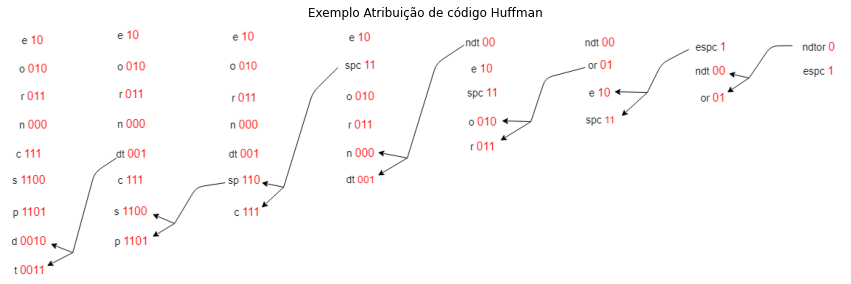

In [34]:
example = cv2.imread("atribuicao_cod.png")
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.imshow(example) 
plt.title('Exemplo Atribuição de código Huffman')
plt.axis('off')
plt.show()

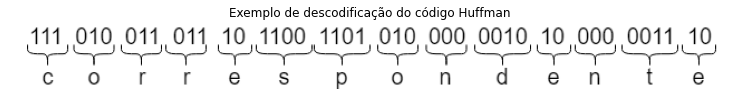

In [35]:
example2 = cv2.imread("exemplo_decode.png")
example2 = cv2.cvtColor(example2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(13, 13))
plt.imshow(example2) 
plt.title('Exemplo de descodificação do código Huffman')
plt.axis('off')
plt.show()

<hr style="border:2px solid black"> </hr>

## Definição da função para obter os simbolos e as respstivas probabilidades 

In [36]:
# gets the characters probabilies on a dictionary
def get_dict_probabilities(symbols):

	# if the data don't have only one dimension it converts to one dimension
	if len(symbols.shape) > 1:
		symbols = symbols.ravel()

	# gets the different numbers and the count of each other
	unique, counts = np.unique(symbols, return_counts=True)

	return unique, counts

## Definição da função da criação da tabela de Huffman

In [37]:
def gen_huff_table(unique, counts):

	# convert the unique value to string
	unique = list(map(str, unique))

	# convert the count of each unique value
	counts = list(counts)

	# associate the unique values and associated count 
	occurences = dict(zip(unique, counts))

	# sort the values based on the count
	occurences = sorted(occurences.items(),key=lambda x:x[1])
	occurences_sorted = dict(occurences)

    # returns the number with the corresponding bits
	if(len(occurences)==2):
		return dict(zip(occurences_sorted.keys(),['1','0']))

	#gets the least and second least characters 
	a1 = (occurences[0][0], occurences[1][0])
	
	#gets the least and second least count of characters
	p1 = (occurences_sorted[a1[0]], occurences_sorted[a1[1]])

	unique.remove(a1[0])
	unique.remove(a1[1])
	counts.remove(p1[0])
	counts.remove(p1[1])

	#adds the least and second least to a new position
	unique.append(a1[0]+","+a1[1])

	#adds the least and second least to count
	counts.append(p1[0]+p1[1])

	# gets the numbers and bits associated 
	table = gen_huff_table(unique,counts)

	# removes the previous value where the two values where associted
	new_table = table.pop(a1[0]+","+a1[1])

	# adds two new entrys with the new values
	table[a1[0]] = new_table+'0'
	table[a1[1]] = new_table+'1'
	return table

## Definição da função que codifica a mensagem através da tabela de Huffman

In [38]:
def encode_huff(message, symbol_code_table):
    # converts the data image to string numbers to one-dimension 
    message = list(map(str,message.ravel()))
    # applys to all the image the codes of the image
    new_message=list(map(lambda x:symbol_code_table[x],message))
    return new_message


## Definição da função para descodificar a mensagem a partir da codificação de Huffman

In [39]:
def decode_huff(message,symbol_code_table):

	# converts the table instead of value -> bits to bits ->  value
	new_code_table = dict([(value,key) for key,value in symbol_code_table.items()])

	# converts bytes to strings
	message = list(map(str,message))

	decode_message = []

	buffer = ""
	for i in range(len(message)):
		# adds a bit to the buffer
		buffer += message[i]

		# if the message exists on the table adds the message
		# to the list
		if buffer in new_code_table:
			decode_message.append(new_code_table[buffer])
			buffer = ""

	return decode_message

## Definição da função para escrever os bytes criados num ficheiro

In [40]:
def convert_string_to_bytes(data):
	b = bytearray()
	#goes in every 8 bits (1 byte) and append the value
	for i in range(0, len(data), 8):
		b.append(int(data[i:i+8], 2))
	return bytes(b)

def writeArray2File(filename, binary_codes):
	#associate all the string
    b = ''.join(binary_codes)
    
    padding = 0
    # loops adding padding (0's) until it's divisible to 8
    while(len(b)%8!=0):
        b += '0'
        # number the bits added
        padding += 1
        
    file=open(filename,'wb')
    
    # converts the padding to bits (max is 3 bits)
    padding_bits = np.binary_repr(padding, width=3)
    b += ''.join(padding_bits)
    
    # writes the content to file
    file.write(convert_string_to_bytes(b))
    file.close()

## Definição da função para remover o padding

In [41]:
def remove_padding(data_file):
    # converts to list the bytes readed
    list_data = list(map(str,data_file))
    # gets the bits added
    padding = int("".join(list_data[-3:]),2)
    # remove the number of bits added
    result = list_data[0:-8-padding]
    return result

## Definição da função para ler os bytes do ficheiro

In [42]:
def readFile2Array(filename):
    file = open(filename,'rb')
    result = np.fromfile(file, dtype=np.uint8)
    result = np.unpackbits(result)
    result = remove_padding(result)
    return result

<hr style="border:2px solid black"> </hr>

# Testes

## Alínea A)

In [48]:
start_time = time.time()

image_color = cv2.imread("LenaColor.tif")

unique, counts = get_dict_probabilities(image_color)
table = gen_huff_table(unique, counts)
print("Time image color:")
print("--- %s seconds ---" % (time.time() - start_time))
print()





start_time = time.time()

image_grey = cv2.imread("LenaGray.tif")

unique, counts = get_dict_probabilities(image_grey)
table = gen_huff_table(unique, counts)
print("Time image grey:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

content = []
with open('DecUniversalDH.txt', 'r+', encoding='utf-8') as f:
    content = f.read()

f.close()

content = content.encode("iso-8859-1", "replace").decode('iso-8859-1')

unique, counts = get_dict_probabilities(np.array(list(content)))
table = gen_huff_table(unique, counts)
print("Time file text:")
print("--- %s seconds ---" % (time.time() - start_time))
print()




start_time = time.time()

# creating a pdf file object
pdfFileObj = open('DecUniversalDH.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

contentPDF = ""
for page in range(pdfReader.numPages):
	contentPDF+= pdfReader.getPage(page).extractText()

unique, counts = get_dict_probabilities(np.array(list(contentPDF)))
table = gen_huff_table(unique, counts)
print("Time pdf text:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

contentMp3 = []
with open('HenryMancini-PinkPanther30s.mp3', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
print("Time mp3:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

contentMid = []
with open('HenryMancini-PinkPantherC.mid', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
print("Time mid:")
print("--- %s seconds ---" % (time.time() - start_time))
print()


Time image color:
--- 0.03989672660827637 seconds ---

Time image grey:
--- 0.029927492141723633 seconds ---

Time file text:
--- 0.0039899349212646484 seconds ---

Time pdf text:
--- 0.08075571060180664 seconds ---

Time mp3:
--- 0.037899017333984375 seconds ---

Time mid:
--- 0.3103301525115967 seconds ---



## Alínea B)

In [49]:
start_time = time.time()

image_color = cv2.imread("LenaColor.tif")

unique, counts = get_dict_probabilities(image_color)
table = gen_huff_table(unique, counts)

print("Time image color:")
print("--- %s seconds ---" % (time.time() - start_time))
p=counts/np.sum(counts)
L=0
for j in range(len(counts)):
    if(counts[j]!=0):
        L+=(counts[j]/len(image_color.ravel())*len(table[str(unique[j])]))
entropia=np.sum(-p*np.log2(p))  
print("Entropia:             ",entropia)
print("Número médio de bits: ",L)
print("Eficiência:           ",entropia/L )
print()

start_time = time.time()

image_grey = cv2.imread("LenaGray.tif")

unique, counts = get_dict_probabilities(image_grey)
table = gen_huff_table(unique, counts)
print("Time image grey:")
print("--- %s seconds ---" % (time.time() - start_time))
p=counts/np.sum(counts)
L=0
for j in range(len(counts)):
    if(counts[j]!=0):
        L+=(counts[j]/len(image_grey.ravel())*len(table[str(unique[j])]))
entropia=np.sum(-p*np.log2(p))  
print("Entropia:             ",entropia)
print("Número médio de bits: ",L)
print("Eficiência:           ",entropia/L )
print()



start_time = time.time()

content = []
with open('DecUniversalDH.txt', 'r+', encoding='utf-8') as f:
    content = f.read()

f.close()

content = content.encode("iso-8859-1", "replace").decode('iso-8859-1')

unique, counts = get_dict_probabilities(np.array(list(content)))
table = gen_huff_table(unique, counts)
print("Time file text:")
print("--- %s seconds ---" % (time.time() - start_time))
p=counts/np.sum(counts)
L=0
for j in range(len(counts)):
    if(counts[j]!=0):
        L+=(counts[j]/len(list(content))*len(table[str(unique[j])]))
entropia=np.sum(-p*np.log2(p))  
print("Entropia:             ",entropia)
print("Número médio de bits: ",L)
print("Eficiência:           ",entropia/L )
print()




start_time = time.time()

# creating a pdf file object
pdfFileObj = open('DecUniversalDH.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

contentPDF = ""
for page in range(pdfReader.numPages):
	contentPDF+= pdfReader.getPage(page).extractText()

unique, counts = get_dict_probabilities(np.array(list(contentPDF)))
table = gen_huff_table(unique, counts)
print("Time pdf text:")
print("--- %s seconds ---" % (time.time() - start_time))
p=counts/np.sum(counts)
L=0
for j in range(len(counts)):
    if(counts[j]!=0):
        L+=(counts[j]/len(list(contentPDF))*len(table[str(unique[j])]))
entropia=np.sum(-p*np.log2(p))  
print("Entropia:             ",entropia)
print("Número médio de bits: ",L)
print("Eficiência:           ",entropia/L )
print()



start_time = time.time()

contentMp3 = []
with open('HenryMancini-PinkPanther30s.mp3', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
print("Time mp3:")
print("--- %s seconds ---" % (time.time() - start_time))
p=counts/np.sum(counts)
L=0
for j in range(len(counts)):
    if(counts[j]!=0):
        L+=(counts[j]/len(list(contentMp3))*len(table[str(unique[j])]))
entropia=np.sum(-p*np.log2(p))  
print("Entropia:             ",entropia)
print("Número médio de bits: ",L)
print("Eficiência:           ",entropia/L )
print()



start_time = time.time()

contentMid = []
with open('HenryMancini-PinkPantherC.mid', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
print("Time mid:")
print("--- %s seconds ---" % (time.time() - start_time))
p=counts/np.sum(counts)
L=0
for j in range(len(counts)):
    if(counts[j]!=0):
        L+=(counts[j]/len(list(contentMp3))*len(table[str(unique[j])]))
entropia=np.sum(-p*np.log2(p))  
print("Entropia:             ",entropia)
print("Número médio de bits: ",L)
print("Eficiência:           ",entropia/L )

Time image color:
--- 0.04199862480163574 seconds ---
Entropia:              7.7501974797431625
Número médio de bits:  7.780607859293619
Eficiência:            0.9960915162284997

Time image grey:
--- 0.029919147491455078 seconds ---
Entropia:              7.445060346118032
Número médio de bits:  7.4675140380859375
Eficiência:            0.99699315035052

Time file text:
--- 0.003988742828369141 seconds ---
Entropia:              4.362360322859398
Número médio de bits:  4.398373983739836
Eficiência:            0.9918120512231167

Time pdf text:
--- 0.08050894737243652 seconds ---
Entropia:              4.364011866372547
Número médio de bits:  4.402162162162162
Eficiência:            0.9913337368356105

Time mp3:
--- 0.038897037506103516 seconds ---
Entropia:              7.98229572420653
Número médio de bits:  7.993470507544589
Eficiência:            0.9986020110629655

Time mid:
--- 0.014948606491088867 seconds ---
Entropia:              5.98795309626177
Número médio de bits:  6.01698

## Alínea C)

In [50]:
start_time = time.time()

image_color = cv2.imread("LenaColor.tif")

unique, counts = get_dict_probabilities(image_color)
table = gen_huff_table(unique, counts)
code = encode_huff(image_color, table)
print("Time image color:")
print("--- %s seconds ---" % (time.time() - start_time))
print()





start_time = time.time()

image_grey = cv2.imread("LenaGray.tif")

unique, counts = get_dict_probabilities(image_grey)
table = gen_huff_table(unique, counts)
code = encode_huff(image_grey, table)
print("Time image grey:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

content = []
with open('DecUniversalDH.txt', 'r+', encoding='utf-8') as f:
    content = f.read()

f.close()

content = content.encode("iso-8859-1", "replace").decode('iso-8859-1')

unique, counts = get_dict_probabilities(np.array(list(content)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(content)), table)
print("Time file text:")
print("--- %s seconds ---" % (time.time() - start_time))
print()




start_time = time.time()

# creating a pdf file object
pdfFileObj = open('DecUniversalDH.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

contentPDF = ""
for page in range(pdfReader.numPages):
	contentPDF+= pdfReader.getPage(page).extractText()

unique, counts = get_dict_probabilities(np.array(list(contentPDF)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentPDF)), table)
print("Time pdf text:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

contentMp3 = []
with open('HenryMancini-PinkPanther30s.mp3', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMp3)), table)
print("Time mp3:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

contentMid = []
with open('HenryMancini-PinkPantherC.mid', 'rb') as f:
    contentMid = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMid)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMid)), table)
print("Time mid:")
print("--- %s seconds ---" % (time.time() - start_time))
print()

Time image color:
--- 0.45375895500183105 seconds ---

Time image grey:
--- 0.4444410800933838 seconds ---

Time file text:
--- 0.010949373245239258 seconds ---

Time pdf text:
--- 0.08477067947387695 seconds ---

Time mp3:
--- 0.17954349517822266 seconds ---

Time mid:
--- 0.043891191482543945 seconds ---



## Alínea D) 

In [51]:
start_time = time.time()

image_color = cv2.imread("LenaColor.tif")

unique, counts = get_dict_probabilities(image_color)
table = gen_huff_table(unique, counts)
code = encode_huff(image_color, table)
writeArray2File("image_color.bin",code)
print("Time image color:")
print("--- %s seconds ---" % (time.time() - start_time))
print("Tamanho antes da compressão",os.path.getsize("LenaColor.tif"))
print("Tamanho depois da compressão",os.path.getsize("image_color.bin"))
print()


start_time = time.time()

image_grey = cv2.imread("LenaGray.tif")

unique, counts = get_dict_probabilities(image_grey)
table = gen_huff_table(unique, counts)
code = encode_huff(image_grey, table)
writeArray2File("image_gray.bin",code)
print("Time image grey:")
print("--- %s seconds ---" % (time.time() - start_time))
print("Tamanho antes da compressão",os.path.getsize("LenaGray.tif"))
print("Tamanho depois da compressão",os.path.getsize("image_gray.bin"))
print()


start_time = time.time()

content = []
with open('DecUniversalDH.txt', 'r+', encoding='utf-8') as f:
    content = f.read()

f.close()

content = content.encode("iso-8859-1", "replace").decode('iso-8859-1')

unique, counts = get_dict_probabilities(np.array(list(content)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(content)), table)
writeArray2File("DecUniversalDH_txt.bin",code)
print("Time file text:")
print("--- %s seconds ---" % (time.time() - start_time))
print("Tamanho antes da compressão",os.path.getsize("DecUniversalDH.txt"))
print("Tamanho depois da compressão",os.path.getsize("DecUniversalDH_txt.bin"))
print()


start_time = time.time()

# creating a pdf file object
pdfFileObj = open('DecUniversalDH.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

contentPDF = ""
for page in range(pdfReader.numPages):
	contentPDF+= pdfReader.getPage(page).extractText()

unique, counts = get_dict_probabilities(np.array(list(contentPDF)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentPDF)), table)
writeArray2File("DecUniversalDH_pdf.bin",code)
print("Time pdf text:")
print("--- %s seconds ---" % (time.time() - start_time))
print("Tamanho antes da compressão",os.path.getsize("DecUniversalDH.pdf"))
print("Tamanho depois da compressão",os.path.getsize("DecUniversalDH_pdf.bin"))
print()


start_time = time.time()

contentMp3 = []
with open('HenryMancini-PinkPanther30s.mp3', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMp3)), table)
writeArray2File("HenryMancini-PinkPanther_mp3.bin",code)
print("Time mp3:")
print("--- %s seconds ---" % (time.time() - start_time))
print("Tamanho antes da compressão",os.path.getsize("HenryMancini-PinkPanther30s.mp3"))
print("Tamanho depois da compressão",os.path.getsize("HenryMancini-PinkPanther_mp3.bin"))
print()

start_time = time.time()

contentMid = []
with open('HenryMancini-PinkPantherC.mid', 'rb') as f:
    contentMid = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMid)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMid)), table)
writeArray2File("HenryMancini-PinkPanther_mid.bin",code)
print("Time mid:")
print("--- %s seconds ---" % (time.time() - start_time))
print("Tamanho antes da compressão",os.path.getsize("HenryMancini-PinkPantherC.mid"))
print("Tamanho depois da compressão",os.path.getsize("HenryMancini-PinkPanther_mid.bin"))
print()

Time image color:
--- 0.7046802043914795 seconds ---
Tamanho antes da compressão 786572
Tamanho depois da compressão 764866

Time image grey:
--- 0.6926703453063965 seconds ---
Tamanho antes da compressão 210122
Tamanho depois da compressão 734088

Time file text:
--- 0.010971307754516602 seconds ---
Tamanho antes da compressão 10322
Tamanho depois da compressão 5411

Time pdf text:
--- 0.3370990753173828 seconds ---
Tamanho antes da compressão 87247
Tamanho depois da compressão 5600

Time mp3:
--- 0.24725985527038574 seconds ---
Tamanho antes da compressão 236925
Tamanho depois da compressão 236733

Time mid:
--- 0.05591750144958496 seconds ---
Tamanho antes da compressão 48049
Tamanho depois da compressão 36140



## Alínea E) 

In [52]:
start_time = time.time()

image_color = cv2.imread("LenaColor.tif")

unique, counts = get_dict_probabilities(image_color)
table = gen_huff_table(unique, counts)
code = encode_huff(image_color, table)
writeArray2File("image_color.bin",code)
readColor=readFile2Array("image_color.bin")
print("Time image color:")
print("--- %s seconds ---" % (time.time() - start_time))
print()


start_time = time.time()

image_grey = cv2.imread("LenaGray.tif")

unique, counts = get_dict_probabilities(image_grey)
table = gen_huff_table(unique, counts)
code = encode_huff(image_grey, table)
writeArray2File("image_gray.bin",code)
readGray=readFile2Array("image_gray.bin")
print("Time image grey:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

content = []
with open('DecUniversalDH.txt', 'r+', encoding='utf-8') as f:
    content = f.read()

f.close()

content = content.encode("iso-8859-1", "replace").decode('iso-8859-1')

unique, counts = get_dict_probabilities(np.array(list(content)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(content)), table)
writeArray2File("DecUniversalDH_txt.bin",code)
readTxt=readFile2Array("DecUniversalDH_txt.bin")
print("Time file text:")
print("--- %s seconds ---" % (time.time() - start_time))
print()


start_time = time.time()

# creating a pdf file object
pdfFileObj = open('DecUniversalDH.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

contentPDF = ""
for page in range(pdfReader.numPages):
	contentPDF+= pdfReader.getPage(page).extractText()

unique, counts = get_dict_probabilities(np.array(list(contentPDF)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentPDF)), table)
writeArray2File("DecUniversalDH_pdf.bin",code)
readPdf=readFile2Array("DecUniversalDH_pdf.bin")
print("Time pdf text:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

contentMp3 = []
with open('HenryMancini-PinkPanther30s.mp3', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMp3)), table)
writeArray2File("HenryMancini-PinkPanther_mp3.bin",code)
readMp3=readFile2Array("HenryMancini-PinkPanther_mp3.bin")
print("Time mp3:")
print("--- %s seconds ---" % (time.time() - start_time))
print()



start_time = time.time()

contentMid = []
with open('HenryMancini-PinkPantherC.mid', 'rb') as f:
    contentMid = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMid)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMid)), table)
writeArray2File("HenryMancini-PinkPanther_mid.bin",code)
readMid=readFile2Array("HenryMancini-PinkPanther_mid.bin")
print("Time mid:")
print("--- %s seconds ---" % (time.time() - start_time))
print()

Time image color:
--- 3.2205653190612793 seconds ---

Time image grey:
--- 3.08034348487854 seconds ---

Time file text:
--- 0.031246423721313477 seconds ---

Time pdf text:
--- 0.18491864204406738 seconds ---

Time mp3:
--- 1.4043982028961182 seconds ---

Time mid:
--- 0.20744681358337402 seconds ---



## Alínea F e G)

In [53]:
start_time = time.time()

image_color = cv2.imread("LenaColor.tif")

unique, counts = get_dict_probabilities(image_color)
table = gen_huff_table(unique, counts)
code = encode_huff(image_color, table)
writeArray2File("image_color.bin",code)
readColor=readFile2Array("image_color.bin")
decode=decode_huff(readColor,table)
print("Time image color:")
print("--- %s seconds ---" % (time.time() - start_time))

image_color = image_color.ravel()
decode = np.array(list(map(int, decode)))
print("Erros: ",np.sum(image_color!=decode))
print()





start_time = time.time()

image_grey = cv2.imread("LenaGray.tif")

unique, counts = get_dict_probabilities(image_grey)
table = gen_huff_table(unique, counts)
code = encode_huff(image_grey, table)
writeArray2File("image_gray.bin",code)
readGray=readFile2Array("image_gray.bin")
decode=decode_huff(readGray,table)
print("Time image grey:")
print("--- %s seconds ---" % (time.time() - start_time))

image_grey = image_grey.ravel()
decode = np.array(list(map(int, decode)))
print("Erros: ",np.sum(image_grey!=decode))
print()






start_time = time.time()

content = []
with open('DecUniversalDH.txt', 'r+', encoding='utf-8') as f:
    content = f.read()

f.close()

content = content.encode("iso-8859-1", "replace").decode('iso-8859-1')

unique, counts = get_dict_probabilities(np.array(list(content)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(content)), table)
writeArray2File("DecUniversalDH_txt.bin",code)
readTxt=readFile2Array("DecUniversalDH_txt.bin")
decode=decode_huff(readTxt,table)
print("Time file text:")
print("--- %s seconds ---" % (time.time() - start_time))

decode = ''.join(decode)
print("Erros: ",np.sum(content!=decode))
print()






start_time = time.time()

# creating a pdf file object
pdfFileObj = open('DecUniversalDH.pdf', 'rb')
  
# creating a pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

contentPDF = ""
for page in range(pdfReader.numPages):
	contentPDF+= pdfReader.getPage(page).extractText()

unique, counts = get_dict_probabilities(np.array(list(contentPDF)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentPDF)), table)
writeArray2File("DecUniversalDH_pdf.bin",code)
readPdf=readFile2Array("DecUniversalDH_pdf.bin")
decode=decode_huff(readPdf,table)
print("Time pdf text:")
print("--- %s seconds ---" % (time.time() - start_time))

decode = ''.join(decode)
print("Erros: ",np.sum(contentPDF!=decode))
print()






start_time = time.time()

contentMp3 = []
with open('HenryMancini-PinkPanther30s.mp3', 'rb') as f:
    contentMp3 = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMp3)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMp3)), table)
writeArray2File("HenryMancini-PinkPanther_mp3.bin",code)
readMp3=readFile2Array("HenryMancini-PinkPanther_mp3.bin")
decode=decode_huff(readMp3,table)
print("Time mp3:")
print("--- %s seconds ---" % (time.time() - start_time))

contentMp3 = np.array(list(contentMp3))
decode = np.array(list(map(int, decode)))
print("Erros: ",np.sum(contentMp3!=decode))
print()





start_time = time.time()

contentMid = []
with open('HenryMancini-PinkPantherC.mid', 'rb') as f:
    contentMid = f.read()


unique, counts = get_dict_probabilities(np.array(list(contentMid)))
table = gen_huff_table(unique, counts)
code = encode_huff(np.array(list(contentMid)), table)
writeArray2File("HenryMancini-PinkPanther_mid.bin",code)
readMid=readFile2Array("HenryMancini-PinkPanther_mid.bin")
decode=decode_huff(readMid,table)
print("Time mid:")
print("--- %s seconds ---" % (time.time() - start_time))


contentMid = np.array(list(contentMid))
decode = np.array(list(map(int, decode)))
print("Erros: ",np.sum(contentMid!=decode))
print()

Time image color:
--- 4.454478025436401 seconds ---
Erros:  0

Time image grey:
--- 4.369959115982056 seconds ---
Erros:  0

Time file text:
--- 0.040120840072631836 seconds ---
Erros:  0

Time pdf text:
--- 0.19550442695617676 seconds ---
Erros:  0

Time mp3:
--- 1.5380682945251465 seconds ---
Erros:  0

Time mid:
--- 0.260495662689209 seconds ---
Erros:  0



<hr style="border:2px solid black"> </hr>

# Conclusão

Após a realização deste trabalho foi compreendida a codificação de Huffman, este algoritmo é do tipo compressão sem perdas. Durante o trabalho foi sentida maior dificuldade na geracão na tabela de Huffman, pois a atribuição do código não estava a ser agregados corretamente. No entanto as dificuldades foram ultrapassadas e foi implementado uma função recursiva para gerar a tabela. O restante do trabalho foi realizado com bastante fluidez, não surgindo nehuma dificuldade em particular. 

Analisando os resultados finais pode-se reparar que não houve qualquer erro entre o ficheiro inicial e o ficheiro final e podemos concluir assim que as funções foram bem implementadas. 
Por fim analisando o tempo que demora a correr cada funçao pode-se reparar que o máximo que demorou foi dezassete segundos o que nos permite concluir que as nossas funções para além de estar bem implementadas, estão bastante eficientes.